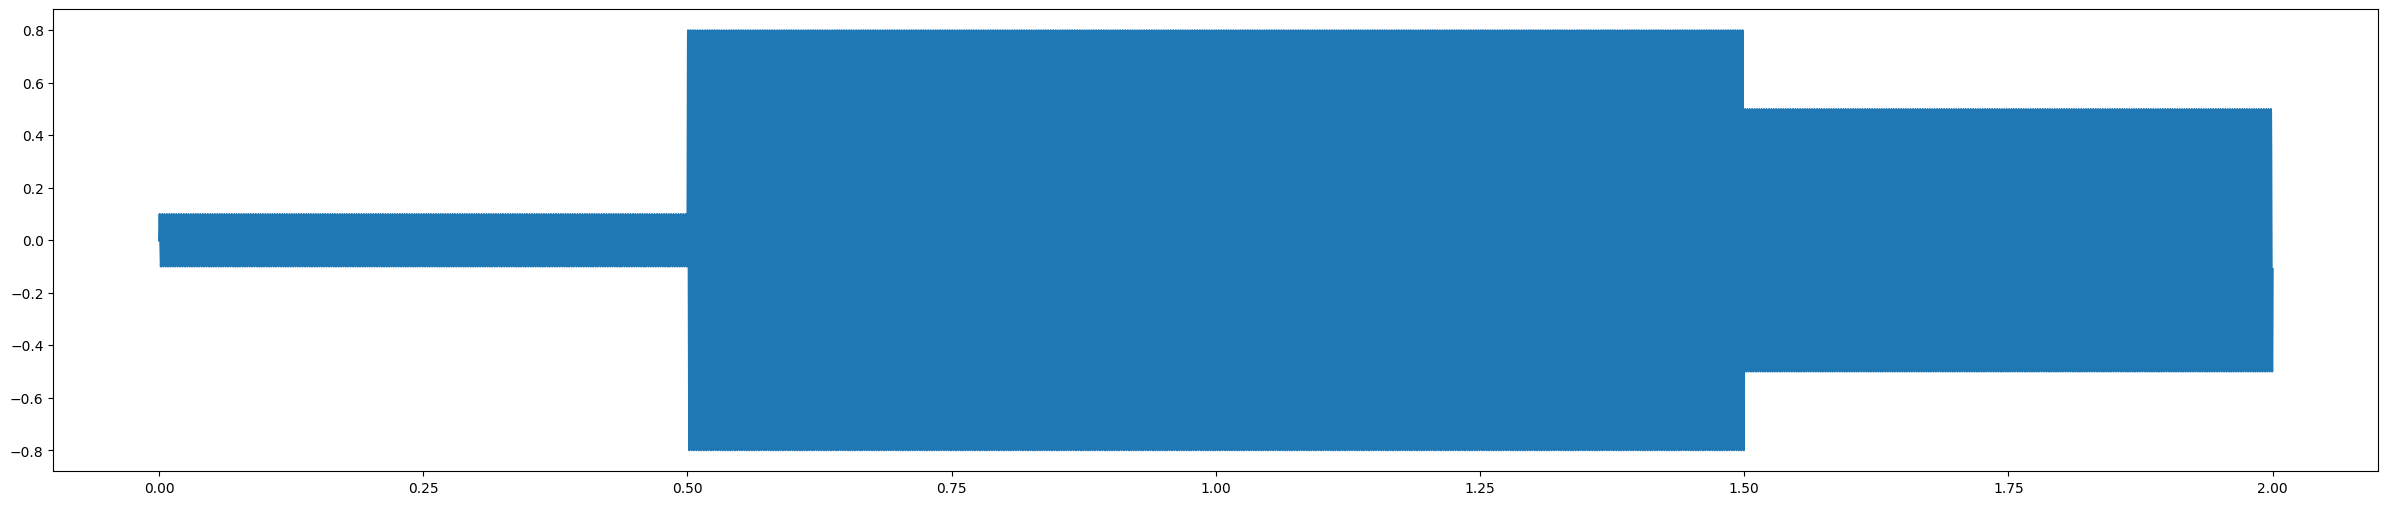

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

def linear_to_db(x):
    return 20 * np.log10(np.abs(x) + 1e-8)

def db_to_linear(db):
    return 10**(db / 20)

PI = 3.1415
sr = 48000

T = -10.0  # Threshold in dB
R = 2.0    # Ratio
W = 9.0    # Knee width in dB
ATT = 10.0  # Attack time in ms
REL = 50.0 # Release time in ms

ATT_COEF = np.exp(-1. / (sr * ATT / 1000.0))
REL_COEF = np.exp(-1. / (sr * REL / 1000.0))

buffer = [0.0 for i in range(2 * sr)]
x_ax = [(i / sr) for i in range(2 * sr)]

for i in range(2 * sr):
    if i < (0.5 * sr):
        buffer[i] = 0.1 * np.sin(440 * 2 * PI * (i / sr))
    else:
        if (i < 1.5 * sr):
            buffer[i] = 0.8 * np.sin(440 * 2 * PI * (i / sr))
        else:
            if (i < 2 * sr):
                buffer[i] = 0.5 * np.sin(440 * 2 * PI * (i / sr))


plt.figure(figsize=(30,6))
plt.plot(x_ax, buffer)
plt.show()


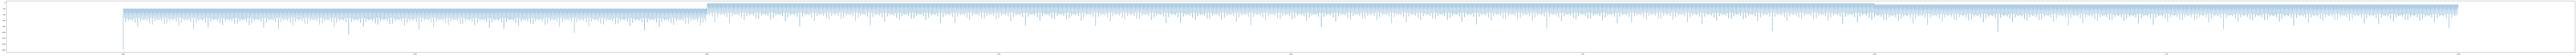

In [23]:
# dB CALCULATIONS

buffer_db = [0.0 for i in range(2 * sr)]
for i, val in enumerate(buffer):
    buffer_db[i] = linear_to_db(val)

plt.figure(figsize=(300,6))
plt.plot(x_ax, buffer_db)
plt.show()

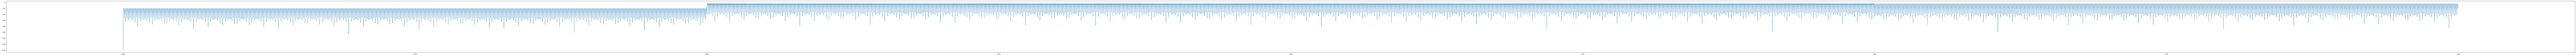

In [24]:
# GAIN COMPUTER

calc_gain = [0.0 for i in range(2 * sr)]
for i, db in enumerate(buffer_db):
    match db:
        case db if 2 * (db - T) <= -W:
            calc_gain[i] = db
        case db if 2 * abs(db - T) <= W:
            calc_gain[i] = db + ((1 / R) * pow((db - T + W/2), 2))/ (2 * W)
        case db if 2 * (db - T) > W:
            calc_gain[i] = T + (db - T) / R

plt.figure(figsize=(300,6))
plt.plot(x_ax, calc_gain)
plt.show()


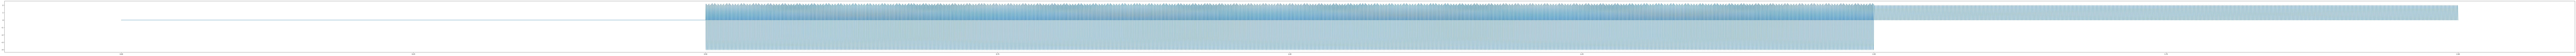

In [25]:
gain_diff = [(calc_gain[i] - buffer_db[i]) for i in range(2 * sr)]
plt.figure(figsize=(300,6))
plt.plot(x_ax, gain_diff)
plt.show()

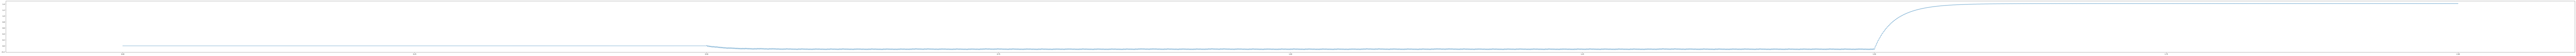

In [26]:
envelope = [0.0 for i in range(2 * sr)]
prev_v = 0.0
for i, diff in enumerate(gain_diff):
    match diff:
        case diff if diff > prev_v:
            val = ATT_COEF * prev_v + (1 - ATT_COEF) * diff
            prev_v = val
            envelope[i] = val
        case diff if diff <= prev_v:
            val = REL_COEF * prev_v + (1 - REL_COEF) * diff
            prev_v = val
            envelope[i] = val

plt.figure(figsize=(300,6))
plt.plot(x_ax, envelope)
plt.show()

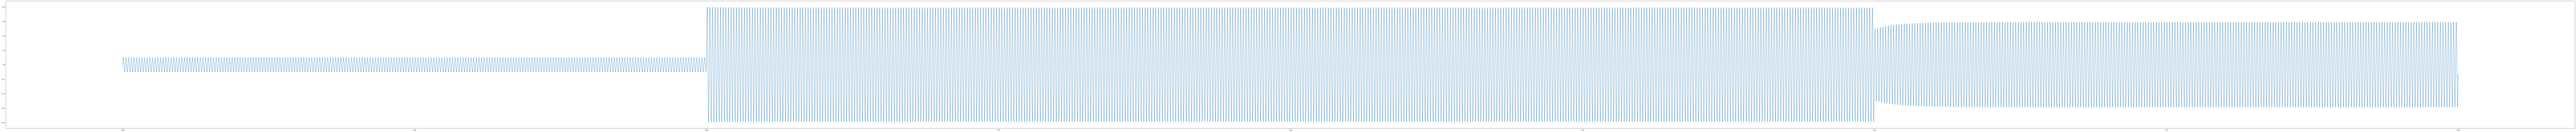

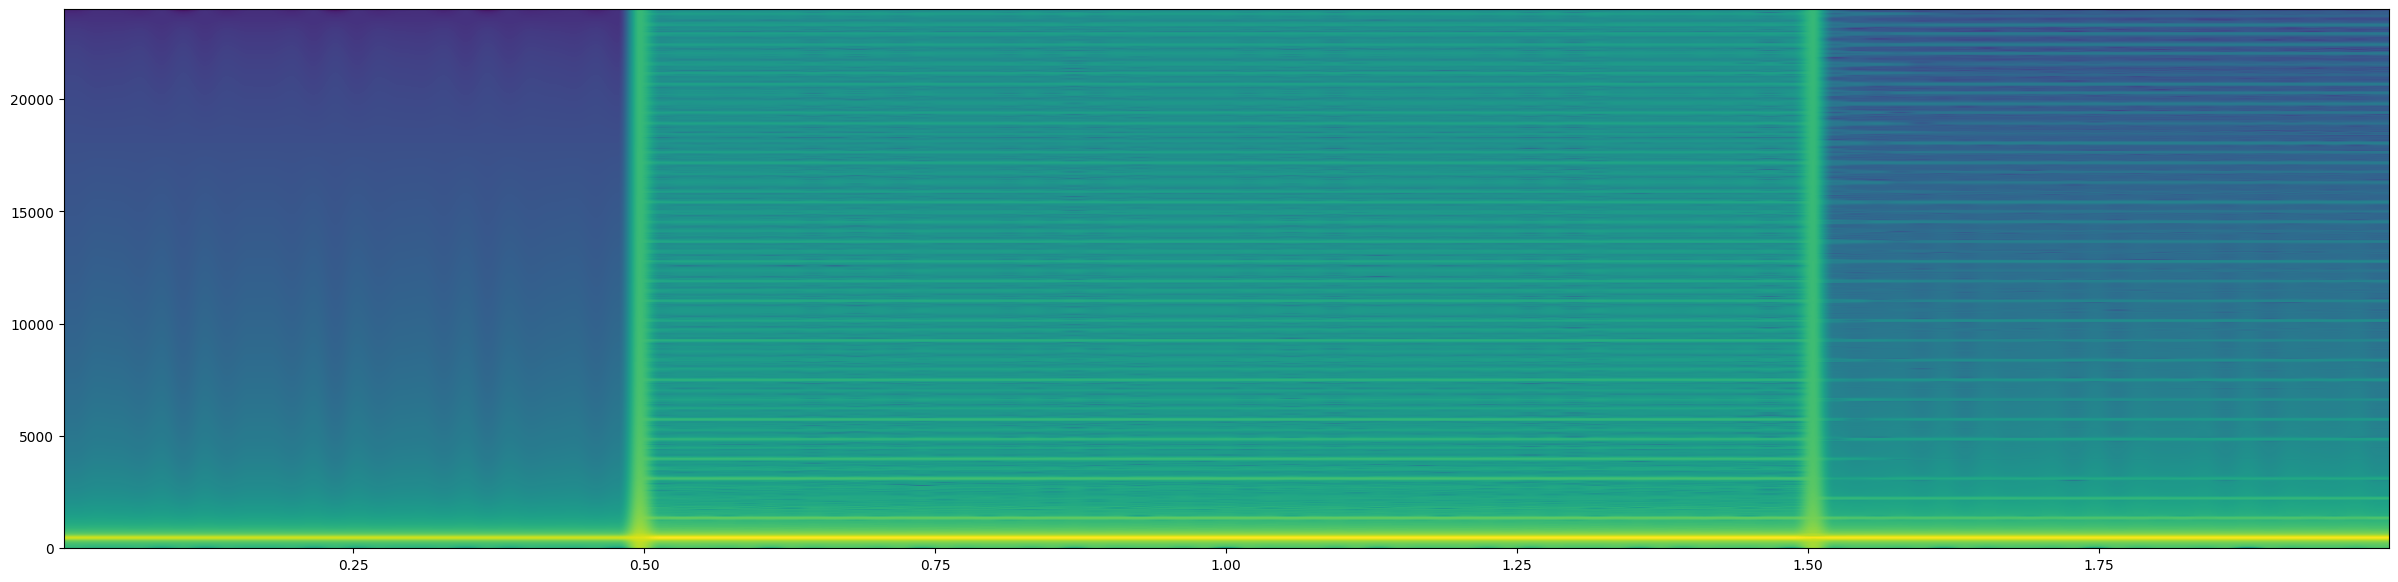

In [27]:
# compressed_db = [(buffer_db[i] - envelope[i]) for i in range(2 * sr)]
compressed_audio = [(buffer[i] * db_to_linear(envelope[i])) for i in range(2 * sr)]

# Convert to 16-bit PCM format
sine_wave_pcm = [np.int16(compressed_audio[i] * 32766) for i in range(2 * sr)]
sine_wave_pcm_np = np.array(sine_wave_pcm)
# Save to a .wav file
write("sine_wave_440Hz.wav", sr, sine_wave_pcm_np)

plt.figure(figsize=(300,15))
plt.plot(x_ax, compressed_audio)
plt.show()

plt.figure(figsize=(30,7))
Pxx, freqs, bins, im = plt.specgram(compressed_audio, NFFT=1024, Fs=sr)
plt.show()